In [56]:
# from sklearn.linear_model import LinearRegression
# from sklearn import metrics
import sklearn
import sklearn.pipeline
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from statsmodels.stats import diagnostic
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv('dataset/machine.data',
        names=['vendor', 'model', 'MYCT', 'MMIN', 'MMAX',
               'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP'])
conv_dict = {
'MYCT': 'machine cycle time in nanoseconds',
'MMIN': 'minimum main memory in kilobytes',
'MMAX': 'maximum main memory in kilobytes',
'CACH': 'cache memory in kilobytes',
'CHMIN': 'minimum channels in units',
'CHMAX': 'maximum channels in units',
'PRP': 'published relative performance',
'ERP': 'estimated from original article'
}

df = df.sort_values('PRP')

In [10]:
df.head(3)

,vendor,model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
99,ibm,370/125-2,480,96,512,0,1,1,6,15
181,siemens,7.521,240,512,1000,8,1,3,6,19
102,ibm,38/3,1100,512,1500,0,1,1,7,18


# Prevendo a performance dos processadores

Inicialmente, tentarei prever a performance dos processadores, assim como o artigo original, usando os dados dos mesmos. Vamos explorar algumas possibilidades, visando melhorar o resultado original, e manipulando diferentes modelos. Para início, temos uma regressão linear simples

In [13]:
X = df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']]
y = df['PRP']
reg = LinearRegression().fit(X, y)
df['lm_pred'] = reg.predict(X)
print(f'Score: {reg.score(X, y)}')
print(f'Coeficientes: {reg.coef_}')
print(f'Intercepto: {reg.intercept_}')

Score: 0.8648906922768672
Coeficientes: [ 0.0488549   0.01529257  0.00557139  0.64140143 -0.27035755  1.48247217]
Intercepto: -55.89393360702415


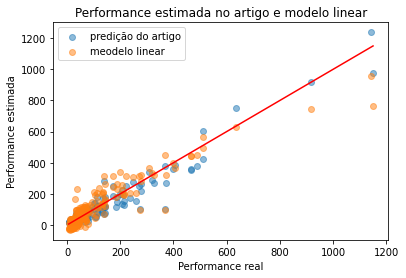

In [14]:
# Comparando o real com o estimado (em caso ideal, identidade y=x)
plt.plot(df['PRP'], df['PRP'], color='red')
plt.scatter(df['PRP'], df['ERP'], alpha=.5, label='predição do artigo')
plt.scatter(df['PRP'], df['lm_pred'], alpha=.5, label='meodelo linear')
plt.title('Performance estimada no artigo e modelo linear')
plt.xlabel('Performance real')
plt.ylabel('Performance estimada')
plt.legend()
plt.show()

In [15]:
# Usando métricas para avaliar ambos modelos
print('Modelo do artigo:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['ERP'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['ERP'])}")
print('Regressão Linear:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['lm_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['lm_pred'])}")

Modelo do artigo:
MSE: 1737.3349282296651
R2: 0.9325117107972016
Regressão Linear:
MSE: 3478.086675615355
R2: 0.8648906922768672


A regressão linear, embora bem razoavel para o problema, ainda teve menor desempenho que o modelo do artigo. Vamos tentar melhora-la. Em primeira abordagem, usarei o teste Goldfeldt-Quant para verificar se a variância dos dados apresenta correlação monótona com minhas features, o que prejudicaria a regressão (heterocedasticidade). Na função abaixo, podemos observar a f-statistic e p-valor resultados do teste, além da ordenação usada.

In [19]:
diagnostic.het_goldfeldquandt(y, X)

(55.023678187774046, 3.549091548850169e-59, 'increasing')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

No caso, como suspeitado, há sim uma correlação entre as features e a variância da variável alvo. O modelo de regressão linear, porém, assume variância constante. Lidando com essa situação, podemos melhorar seu desempenho. Como alternativa, tentarei usar o modelo de regressão linear com pesos. A idéia é associar a cada ponto um peso baseado na variância do valor fitado, o que normalizará a variância do modelo. Primeiro, vou regredir a variancia dos dados.

In [71]:
v = []
for i in range(50):
    ls = list(map(lambda x:x/50*len(df), range(51)))
    t = df.iloc[int(ls[i]) : int(ls[i+1])-1]
    v.extend([np.var(t['PRP'])]*len(t))
    
# LinearRegression().fit(X, v).preict(X)

In [27]:
wls_model = sm.WLS(y,X)
results = wls_model.fit()
print(results.summary())
df['lm2_pred'] = results.predict(X)

                                 WLS Regression Results                                
Dep. Variable:                    PRP   R-squared (uncentered):                   0.603
Model:                            WLS   Adj. R-squared (uncentered):              0.592
Method:                 Least Squares   F-statistic:                              51.47
Date:                Wed, 08 Jun 2022   Prob (F-statistic):                    3.34e-38
Time:                        12:27:52   Log-Likelihood:                         -1298.8
No. Observations:                 209   AIC:                                      2610.
Df Residuals:                     203   BIC:                                      2630.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

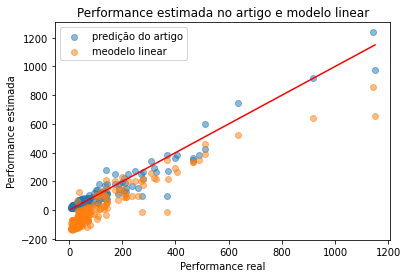

In [30]:
# Comparando o real com o estimado (em caso ideal, identidade y=x)
plt.plot(df['PRP'], df['PRP'], color='red')
plt.scatter(df['PRP'], df['ERP'], alpha=.5, label='predição do artigo')
plt.scatter(df['PRP'], df['lm2_pred'], alpha=.5, label='meodelo linear')
plt.title('Performance estimada no artigo e modelo linear')
plt.xlabel('Performance real')
plt.ylabel('Performance estimada')
plt.legend()
plt.show()

In [28]:
# Usando métricas para avaliar ambos modelos
print('Modelo do artigo:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['ERP'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['ERP'])}")
print('Regressão Linear:')
print(f"MSE: {sklearn.metrics.mean_squared_error(df['PRP'], df['lm2_pred'])}")
print(f"R2: {sklearn.metrics.r2_score(df['PRP'], df['lm2_pred'])}")

Modelo do artigo:
MSE: 1737.3349282296651
R2: 0.9325117107972016
Regressão Linear:
MSE: 14634.095581089134
R2: 0.43152580498434656
